# Lecture 4

## Lecture learning goals

By the end of the lecture you will be able to:

1. Visualize distributions.
1. Understand how different distribution plots are made and their pros and cons.
1. Select an appropriate distribution plot for the situation.
1. Grasp EDA on a conceptual levels both for numerical and categorical variables.
1. Create density plots to compare a few distributions.
1. Create boxplots and violin plot to compare many distributions.
1. Use repeated plot grids to investigate multiple data frame columns in the same plot.
1. Visualize correlations and counts of categorical variables.

## Readings

- Chapter 7 and 9 of [Fundamentals of Data Visualization](https://clauswilke.com/dataviz/histograms-density-plots.html). No other notes will be posted, since we didn't include any code of our own and these sections are very close to what I would want to write myself so use this reference and the videos when studying.
- [Interactive flow chart](https://www.data-to-viz.com/) for which visualization to choose. Not really anything to read, but go there to look around and bookmark it to use as a reference when needed throughout this course and others.
- [Section 6 of Fundamentals of Data visualization](https://clauswilke.com/dataviz/visualizing-amounts.html).

## Visualizing distributions fairly

### Barplots

Barplots hide details of distributions by showing only 1 values (or 3 with error bars).
Below is an example of this from a [scientific article on how to present data accurately](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002128).
You can see that the bars could hide widely different data distributions,
which would lead to different interpretations of he experiment
both visually from looking at the points
and by examining formal statistical comparisons
(the table below the figure,
you don't need to know exactly what these are
just note how different they are from different distributions).

![image.png](img/barplot-hiding-points.png)

### Boxplots

Boxplots are better (5-9 values) but can also hide important information.
I have included a couple of examples showing how different plot types change when the data changes.
This is from [Autodesk Research](https://www.autodesk.com/research/publications/same-stats-different-graphs)
who also made the animation of the datasaurus we saw in lecture 1.

![](img/hist-point-box.gif)

![](img/point-box-violin.gif)

### Kernel density estimates

The animation below shows how a KDE is constructed
from first adding individual kernels (curves) centered on each data point and then summing them together
(created from [this YouTube video](https://youtu.be/DCgPRaIDYXAvideo)):

![](img/kde-buildup.gif)

[Scikit learn's documenation on KDEs is great](https://scikit-learn.org/stable/modules/density.html#density-estimation) and includes images comparing with histograms and also visualizing the different kernels that could be used.

![image.png](img/distributions.png)

![image.png](img/kernels.png)

## Distribution plots

We will use a movie data set similar to from lab 2.

In [1]:
movies = pd.read_json('data/lec2-movies.json')
movies

NameError: name 'pd' is not defined

Let's recall how to make a histogram,
using the runtime of the movies.

In [ ]:
(alt.Chart(movies).mark_bar().encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()'))

What if we want to facet the histogram by country?
Since the `'country'` column consists of lists with one or more labels,
we need to unpack these list so that we have one country in each row.
This means that movies that have multiple production countries, 
will be duplicated in the dataframe and counted once per country.
In this case,
this is the most sensible thing to do,
but in general it is good to be careful when doing an operation like this
since it could lead to unwanted replicates
(and we would not want to have duplicated rows 
if we are not faceting or coloring by that variable).

Unpacking a list is done via the [`explode` method of pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html)
and there is a illustrative example in the documentation to help understand the outcome of this operation:

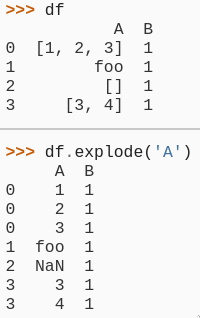

In [ ]:
boom_countries = movies.explode('countries')
(alt.Chart(boom_countries).mark_bar().encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()')
 .facet('countries'))

By default when faceting,
the y-axis is the same for all plots so that they are easy to compare,
but we could also make it independent for each plot.

In [ ]:
(alt.Chart(boom_countries).mark_bar().encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()')
 .facet('countries')
 .resolve_scale(y='independent'))

If we want to color our faceted plots by the movie genre,
we need to explode also the `'genres'` column in the df.

In [ ]:
boom_both = boom_countries.explode('genres')
(alt.Chart(boom_both).mark_bar().encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()',
    color='genres')
 .facet('countries'))

We can get a rough indication of the genre differences from this plot,
but as we have mention previously,
it is not ideal to be looking at bars with different baselines.
Instead we could draw a line for the histograms,
since this will not stack on top of each other,
but start from the same point of the y-axis.

In [ ]:
(alt.Chart(boom_both).mark_line().encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()',
    color='genres')
 .facet('countries'))

To make the lines appearance more histogram-like,
we could change the interpolation method.
This refers to how the line behaves between two data points
and the default is to draw a diagonal line between data points
(euclidean distance/linear interpolation).
If we instead use step-wise interpolation ([taxicab geometry/manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)),
it looks more like a histogram.
But please note that I am only showing this for demonstration purposes,
this does not quite behave as a histogram and should not be used as such
as per [this GitHub comment from the Altair author](https://github.com/altair-viz/altair/issues/1701#issuecomment-534398358) (until this issue is fixed).

In [ ]:
(alt.Chart(boom_both).mark_line(interpolate='step').encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()',
    color='genres')
 .facet('countries'))

We could also prefer a [monotone cubic interpolation](https://en.wikipedia.org/wiki/Monotone_cubic_interpolation),
which essentially entails rounding the corners
while preserving the one-directional (monotone) properties of a linear interpolation
(i.e. make sure the line does not wiggle up and down between data points,
but proceed gradually from one to the next).

In [ ]:
(alt.Chart(boom_both).mark_line(interpolate='monotone').encode(
    alt.X('runtime', bin=alt.Bin(maxbins=30)),
    y='count()',
    color='genres')
 .facet('countries'))

While this looks similar to a kernel density estimate (KDE),
it is not the same thing and should not be used as such
(but it is useful for changing the appearance of line plots in general).

To visualize a KDE,
we need to do two things:

1. Calculate the KDE (adding the individual Gaussian kernels and summing them together)
2. Plot a line or area mark for the newly calculated KDE values.

In Altair,
these operations are done in two explicit steps,
whereas ggplot has a `geom_` that does both in the same step.

In [ ]:
(alt.Chart(movies)
 .transform_density(
    'runtime',
    as_=['runtime', 'density'])  # Give a name to the KDE values, which we can use when plotting
 .mark_area(interpolate='monotone').encode(
    x='runtime',
    y='density:Q'))

In the above,
we need to use `':Q'` to indicate that the density is numeric 
since it is not part of the dataframe,
so Altair cannot use the pandas data types to figure out that it is numeric.

If we want to color by a categorical variable,
we need to add an explicit `groupby` 
when calculating the density also,
so that there is one density calculation
per color variable (`genres` in this case).

In [ ]:
boom_genres = movies.explode('genres')
(alt.Chart(boom_genres)
 .transform_density(
     'runtime',
     groupby=['genres'],
     as_=['runtime', 'density'])
 .mark_area(interpolate='monotone').encode(
     x='runtime',
     y='density:Q',
     color='genres'))

To make the curves smoother,
we could use the monotone interpolation mentioned above,
but a more proper way of doing this is to increase the resolution
over which the KDE is calculated
by setting the steps size to a higher number.

In [ ]:
(alt.Chart(boom_genres)
 .transform_density(
     'runtime',
     groupby=['genres'],
     as_=['runtime', 'density'],
     steps=200)
 .mark_area().encode(
     x='runtime',
     y='density:Q',
     color='genres'))

Lastly, we could make the histograms slightly transparent so that it is easier to see the overlap.

In [ ]:
(alt.Chart(boom_genres)
 .transform_density(
     'runtime',
     groupby=['genres'],
     as_=['runtime', 'density'],
     steps=200)
 .mark_area(opacity=0.4).encode(
     x='runtime',
     y='density:Q',
     color='genres'))

If we face these,
you will notice that they look quite different from the faceted histograms.
This is because the density rather than the count is shown by default on the y-axis.
Showing the density means that we can see how the area adds up to one,
but is not really a useful numbers for us to know.

In [ ]:
(alt.Chart(boom_both)
 .transform_density(
     'runtime',
     groupby=['genres', 'countries'],
     as_=['runtime', 'density'])
 .mark_area(interpolate='monotone').encode(
     x='runtime',
     y='density:Q',
     color='genres')
 .facet('countries'))

We could instead scale it by the count,
but again this is not that useful,
as it is not as clear how to interpret this,
compared to a histogram with discrete bins and a count in each bin.

In [ ]:
(alt.Chart(boom_both)
 .transform_density(
     'runtime',
     groupby=['genres', 'countries'],
     as_=['runtime', 'density'],
     counts=True)
 .mark_area(interpolate='monotone').encode(
     x='runtime',
     y='density:Q',
     color='genres')
 .facet('countries'))

So in summary for densities,
the important is the shape to see how the values are distributed,
and possibly the size if you scale them,
but just as a relative indicator versus other densities
rather than relying too much on the exact values on the y-axis.

Here,
we could also use `row` and `columns` parameters to faceting
in order to separate the categorical variables further.
This is especially useful if we would have had a third categorical column,
so I made a true/false column for whether the movie had a high rating or not.
You will see that the the densities don't work that well with this split,
but other marks would.

In [ ]:
boom_both['vote_avg_over_4'] = boom_both['vote_average'] > 3
(alt.Chart(boom_both)
 .transform_density(
     'runtime',
     groupby=['genres', 'countries', 'vote_avg_over_4'],
     as_=['runtime', 'density'],
     counts=True)
 .mark_line().encode(
     x='runtime',
     y='density:Q',
     color='genres')
 .properties(height=100)
 .facet(column='countries', row='vote_avg_over_4')
 .resolve_scale(y='independent'))

### In ggplot

In [ ]:
%%R
library(rjson)
library(tidyverse)
movies <- fromJSON(file = 'data/lec2-movies.json') %>%
    as_tibble() %>%
    unnest(-c(countries, genres))
    
head(movies)

Let's recall how to make a histogram.

In [ ]:
%%R -w 500 -h 350
ggplot(movies) +
    aes(x = runtime) +
    geom_histogram(color = 'white')

In ggplot,
there is a specific `geom` for densities
which does both the KDE calculation and plots a line.

In [ ]:
%%R -w 500 -h 350
ggplot(movies) +
    aes(x = runtime) +
    geom_density()

We can still control the parameters of the KDE calculation like in Altair,
for example the bandwidth,
how wide each kernel is
(similar to histogram bin width).

In [ ]:
%%R -w 500 -h 350
ggplot(movies) +
    aes(x = runtime) +
    geom_density(bw=1)

In [ ]:
%%R -w 500 -h 350
ggplot(movies) +
    aes(x = runtime) +
    geom_density(bw=100)

Filling the density can make it look a bit nicer.

In [ ]:
%%R -w 500 -h 350
ggplot(movies) +
    aes(x = runtime) +
    geom_density(fill = 'grey', alpha = 0.7)

To color/fill by a variable,
we don't need a separate groupby,
but can treat `geom_density` like any other geom,
which is convenient.
In dplyr,
a list can be unpacked via the `unnest` function.

In [ ]:
%%R -w 500 -h 350
free_genres <- movies %>% unnest(genres)
ggplot(free_genres) +
    aes(x = runtime,
        fill = genres,
        color = genres) +
    geom_density(alpha = 0.6)

We need to unpack both `genres` and `countries`
if we want to use aesthetic mappings for both these columns.

In [ ]:
%%R -w 700 -h 350
free_both <- free_genres %>%
    unnest(countries)
ggplot(free_both) +
    aes(x = runtime,
        fill = genres,
        color = genres) +
    geom_density(alpha = 0.6) +
    facet_wrap(~countries)

To map the rows and columns of the plot grid to variables in the data set,
we can use `facet_grid` instead of `facet_wrap`.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        fill = genres,
        color = genres) +
    geom_density(alpha = 0.6) +
    facet_grid(genres ~ countries)

## Comparing distributions for multiple categorical variables along the y-axis

While it is possible to make [violin plots](https://altair-viz.github.io/gallery/violin_plot.html)
and [stripplots](https://altair-viz.github.io/gallery/stripplot.html) (categorical scatter plots) in Altair,
these do currently not work with a categorical x/y axies,
and you need to use faceting instead to display different categories,
which gives us less flexibility.
Therefore,
we will primarily use boxplots when comparing multiple distributions with Altair.

In [ ]:
(alt.Chart(boom_both)
 .mark_boxplot().encode(
     x='runtime',
     y='genres',
     color='genres')
 .facet('countries', columns=1))

The size of the boxes can be made proportional to the count of observations
in that group.
We could also have used barplot for this,
if we needed a more precise indication of the counts.

In [ ]:
(alt.Chart(boom_both)
 .mark_boxplot().encode(
     x='runtime',
     y='genres',
     color='genres',
     size='count()')
 .facet('countries', columns=1))

Since I personally like seeing distributions,
I also invented these 8-bit looking violins made out of square marks.

In [ ]:
squareolins = (alt.Chart(boom_both)
 .mark_square().encode(
     x='runtime',
     y='genres',
     color='genres',
     size='count()'))
squareolins.facet('countries', columns=1)

We could add a mean dot.
Below I recreate the chart
since there is no good way to remove the size and color encodings
that we had in the chart above
(and we don't want to color or resize the means).
I could have done these plots in the opposite order 
and avoided having to code the entire chart twice,
just changing the mark and the necessary encoding.

In [ ]:
means = (
    alt.Chart(boom_both)
    .mark_circle(color='white').encode(
        x='mean(runtime)',
        y='genres'))
(squareolins + means).facet('countries', columns=1)

This is one thing I appreciate with Altair 
(and graphical grammars in general):
understanding how to compose plots from individual elements,
allows you some creativity in what you make
versus using a pre-made plot via a set name (stripplot, violinplot, etc).
You should of course be very careful with this 
because the common plots exist for good reason,
they are statistically robust in many cases,
and common enough that they are easier for people to interpret
than your own creations in many cases.

### In ggplot

ggplot has a boxplot geom.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_boxplot() +
    facet_wrap(~countries)

Which we can scale by the count of observations.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_boxplot(varwidth = TRUE) +
    facet_wrap(~countries)

There is also a geom for creating violin plots
which both calculates the density and then plots
a line and an area.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_violin() +
    facet_wrap(~countries)

These can also be scaled by size.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_violin(scale = 'count') +
    facet_wrap(~countries)

We can show the quantiles shown in the box plot also on the violin.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +
    facet_wrap(~countries)

As we discussed in the previous lecture,
it is always a good idea to have a look at 
where the individual data points are.
For this we can use a categorical scatter plot
where the dots are spread/jittered randomly on the non-value axis
so that they don't all overlap via `geom_jitter`.

In [ ]:
%%R -w 700 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = genres) +
    geom_jitter(height = 0.2, alpha = 0.3) +
    geom_violin() +
    facet_wrap(~countries)

ggplot understand that if you color by a variable,
it should create separate violins for each group on the same location
of the categorical axis.
In Altair,
this would be a bit more cumbersome since we would need to use different facets.

In [ ]:
%%R -w 500 -h 350
ggplot(free_both) +
    aes(x = runtime,
        y = genres,
        fill = countries) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))

You could also [use density lines in so called ridgeline plots to compare many distributions](https://www.r-graph-gallery.com/294-basic-ridgeline-plot.html).

## Repeating plots for different columns

### Repeating columns on a single axis

Previously we have made subplots via faceting,
which creates one subplot per unique value in a categorical column
and displays the same numerical columns in all the subplots/facets.
This view of multiple subsets in the data
is often called a trellis plot or plot of small multiples.
Here,
we will see how we can create subplots that each display all the data points,
but is repeated for different columns in the data.

We specify which columns we want to use via the `.repeat` method,
and where we want to use them via `alt.repeat`.
For this plot,
we keep the y-axis constant,
and repeat the plot for different x-axis columns.

In [ ]:
(alt.Chart(boom_both)
 .mark_boxplot().encode(
     alt.X(alt.repeat(), type='quantitative'),
     y='genres',
     color='genres',
     size='count()')
 .repeat(['runtime', 'revenue']))

This is very powerful for quick data exploration,
and uses a consistent grammar 
which gives you lots of flexibility for customization
instead of having a specific function that made only this type of plot
(which is common elsewhere).

You can even combine facet and repeat but note that this does not work with all marks yet,
although for boxplots it is fine. 

In [ ]:
(alt.Chart(boom_both).mark_boxplot().encode(
    alt.X(alt.repeat(), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y('genres', title=''), # Removing labels to make the chart less busy
    color='genres')
 .properties(height=100, width=250)
 .facet(row='countries')
 .repeat(repeat=['runtime', 'revenue']))

## Repeating columns on both axes

To efficiently repeat over both the axis,
we can use the `column` and `row` parameter to `repeat`.
These work similarly as they do for `facet`,
distributing the list of data frame variables 
over only one axis,
which we specify with `alt.repeat` to the x and y axis.

In [ ]:
(alt.Chart(boom_both)
 .mark_boxplot().encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='nominal', title=''),
     alt.Color(alt.repeat('column'), type='nominal', title='Genre or Country'))
 .properties(height=100, width=250)
 .repeat(column=['genres', 'countries'], row=['runtime', 'revenue']))

When we don't give any named parameters to `repeat` and `alt.repeat`,
they use the default,
which is `repeat` and then you wrap with `columns=2` if you want more than one row
as we did above.

We could also use this technique to create a what is usually called a scatter plot matrix (or pairplot),
where we repeat numerical columns on both axes to investigate their pairwise relationships.

In [ ]:
(alt.Chart(boom_both)
 .mark_point().encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative'))
 .properties(width=200, height=200)
 .repeat(column=['runtime', 'revenue'], row=['runtime', 'revenue']))

When there are many plots,
it can be hard to see,
so as long as this is just for our own exploratory analysis,
it can be a good idea to hide the labels or make them much smaller
(possible toggling back on and off if we need to check an axis range).
To avoid saturation (overplotting) we can make the dots smaller
and a bit transparent.

In [ ]:
(alt.Chart(boom_both)
 .mark_point(size=2, opacity=0.2).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative'))
 .properties(width=200, height=200)
 .repeat(column=['runtime', 'revenue'], row=['runtime', 'revenue'])
 .configure_axis(labels=False))

It is still a bit hard to see exactly where  most of the dots are,
so we could create a binned count plot instead for a more accurate representation.

In [ ]:
# could also use alt.axis
(alt.Chart(boom_both)
 .mark_rect().encode(
     alt.X(alt.repeat('row'), type='quantitative', bin=alt.Bin(maxbins=20)),
     alt.Y(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
     alt.Color('count()'))
 .properties(width=200, height=200)
 .repeat(column=['runtime', 'revenue'], row=['runtime', 'revenue'])
 .configure_axis(labels=False))

### In ggplot

There is not "repeat" function in ggplot,
so we would first need to pivot all data frame variables
into the same column and then use faceting on this new column name.

In [ ]:
%%R -w 800 -h 550
movies %>%
    select_if(is.numeric) %>%
    pivot_longer(everything()) %>%
    ggplot(aes(x = value)) + 
        geom_density(fill = 'grey') + 
        facet_wrap(~name, scales = 'free')

This would not work if both axes are numerical,
but luckiy there is an extension packagge for ggplot called GGally,
which can be used here.
It also plots the density curves on the diagonal and the correlations on top.

In [ ]:
%%R -w 800 -h 550
GGally::ggpairs(movies %>% select_if(is.numeric), progress = FALSE)

This function can also show info on categorical variables.

In [ ]:
%%R -w 800 -h 550
GGally::ggpairs(free_both %>% select(-title), progress=FALSE)

And color by another categorical.

In [ ]:
%%R -w 800 -h 550
GGally::ggpairs(free_both %>% select(-title), aes(color = countries), progress=FALSE)

Customizing these plots are possible but  bit cumbersome,
[this blog post has some good examples)[https://www.blopig.com/blog/2019/06/a-brief-introduction-to-ggpairs/).

In [ ]:
%%R -w 800 -h 550
GGally::ggpairs(
    free_both %>% select(-title),
    aes(color = countries),
    progress = FALSE,
    lower = list(continuous = GGally::wrap('points', alpha = 0.3, size=0.1, color = 'steelblue')),
    diag = list(continuous = GGally::wrap('densityDiag', fill = 'coral', alpha = 0.4))) 

## Correlation plots

A good complement to a scatter plot matrix is a correlation plot
which helps formalize the correlation between numerical variables.
Using "spearman" correlation instead of "pearson" 
allows us to detect non-linear relationships better.

In [ ]:
corr_df = (
    movies
    .select_dtypes('number')
    .corr('spearman')
    .abs()                      # Use abs for negative correlation to stand out
    .stack()                    # Get df into long format for altair
    .reset_index(name='corr'))  # Name the index that is reset to avoid name collision

alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='corr',
    color='corr')

With some effort, we can make it look nicer.

In [ ]:
corr_df = movies.select_dtypes('number').corr('spearman').stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0
corr_df['abs'] = corr_df['corr'].abs()
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='abs',
    color=alt.Color('corr', scale=alt.Scale(scheme='blueorange', domain=(-1, 1))))

The domain argument sets the extent of the colorscale
(from a perfect negative to a perfect positive correlation), 
we will talk more about colorscale later in the course.

### In ggplot

We could do the separate calculation in ggplot as well,
but there is also a special function in GGally,
which does the computation and visualizes it as a heatmap.

In [ ]:
%%R -w 600 -h 350
GGally::ggcorr(movies)

## Counting combinations of categorical groups

Counting categoricals is helpful to get and overview of where most observations lie.
Often the size and color can be used for this, 
similar to the correlation plot.

In [ ]:
alt.Chart(boom_both).mark_square().encode(
    x='genres',
    y='countries',
    color='count()',
    size='count()')

Or a heatmap could be created
(we could have done this for the correlation plot as well).

In [ ]:
alt.Chart(boom_both).mark_rect().encode(
    x='genres',
    y='countries',
    color='count()')

For more precise counts,
we could use a faceted bar chart.

In [ ]:
alt.Chart(boom_both).mark_bar().encode(
    x='count()',
    y='genres',
    color='genres').facet(row='countries')

### In ggplot

GGally has a similar plot for counting categories.

In [ ]:
%%R -w 600 -h 350
GGally::ggally_cross(free_both, aes(x = genres, y = countries))

A barplot of counts could be made directly in ggplot.

In [ ]:
%%R -w 600 -h 350
ggplot(free_both) +
    aes(y = countries,
        fill = genres) +
    geom_bar(stat = 'count', position = 'dodge')